In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scqubits
from functools import partial
import qutip
import concurrent
from loky import get_reusable_executor
import numpy as np
import qutip
import scqubits
from typing import List, Union,Any

from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.drive import *
from CoupledQuantumSystems.evo import ODEsolve_and_post_process
from CoupledQuantumSystems.noise import *
from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.IFQ import gfIFQ


In [8]:
from scipy.optimize import minimize

EJ = 4
EC = EJ/2.7
EL = EJ/45

qbt = gfIFQ(EJ = EJ,EC =EC,EL = EL,truncated_dim=20)

temp_in_mK = 20
loss_tangent_ref = 5e-6
one_over_f_flux_noise_amplitude = 1e-6

c_ops=qbt.get_T1_c_ops(temp_in_mK,
                        loss_tangent_ref,
                        one_over_f_flux_noise_amplitude)
e_ops = [qutip.ket2dm(qutip.basis(qbt.truncated_dim, i)) for i in range(12)]


 /tmp/ipykernel_712333/4027375258.py: 91

In [9]:
from IPython.display import clear_output

t_duration = 50
tlist = np.linspace(0,t_duration,t_duration)
detuning = 0.2

[0.87200222 0.84961215 0.11506159 0.11097494]


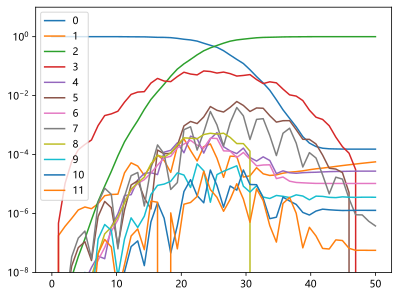

(2.9205068614368557e-05, 0.0002411816830855118)


In [10]:
def objective(x):
    amp1_scaling_factor = x[0]
    amp2_scaling_factor = x[1]
    amp1_correction_scaling_factor = x[2]
    amp2_correction_scaling_factor = x[3]
    results  = qbt.run_qutip_mesolve_parrallel(
        initial_states = [qutip.basis(qbt.truncated_dim, 0),qutip.basis(qbt.truncated_dim, 2)],
        tlist = tlist,
        drive_terms = qbt.get_Raman_DRAG_drive_terms(
            shape = 'gaussian',
            i = 0,
            j = 3,
            k = 2,
            detuning=detuning,
            t_duration=t_duration,
            amp1_scaling_factor = amp1_scaling_factor,
            amp2_scaling_factor = amp2_scaling_factor,
            amp1_correction_scaling_factor = amp1_correction_scaling_factor,
            amp2_correction_scaling_factor = amp2_correction_scaling_factor,
        ),
        c_ops = c_ops,
        e_ops = e_ops
    )
    clear_output()
    print(x)
    for i, exp in enumerate(results[0].expect):
        plt.plot(tlist,exp,label= f"{i}")
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-8,1e1)
    plt.show()
    
    one_minus_pop2 = np.abs( 1- (results[0].expect[2][-1] + 0.98* results[0].expect[1][-1]))
    one_minus_pop0 = np.abs(1- (results[1].expect[0][-1] +  0.98* results[1].expect[1][-1]))
    print((one_minus_pop2, one_minus_pop0))
    return one_minus_pop2 + one_minus_pop0

initial_guess = [0.8727789,  0.84847549, 0.1110832,  0.10927272]


result = minimize(objective, initial_guess, method='Nelder-Mead')
